# Text Wrangling and Regex

Adapted from Lisa Yan, Will Fithian, Joseph Gonzalez, Deborah Nolan, Sam Lau

Updated by Bella Crouch

Working with text: applying string methods and regular expressions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
import pandas as pd
import re

## Demo 1: Canonicalising County Names

In [2]:
states = pd.read_csv("../DATA/county_and_state.csv")
populations = pd.read_csv("../DATA/county_and_population.csv")

# display allows us to view a DataFrame without returning it as an object
display(states)

populations

,County,State
0,De Witt County,IL
1,Lac qui Parle County,MN
2,Lewis and Clark County,MT
3,St John the Baptist Parish,LS


,County,Population
0,DeWitt,16798
1,Lac Qui Parle,8067
2,Lewis & Clark,55716
3,St. John the Baptist,43044


Both of these DataFrames share a "County" column. Unfortunately, formatting differences mean that we can't directly merge the two DataFrames using the "County"s.

In [3]:
states.merge(populations, left_on = "County", right_on = "County")

,County,State,Population


To address this, we can **canonicalize** the "County" string data to apply a common formatting.
Things to do
* lower case everything
* remove space
* replace &
* remove dot
* remove county
* remove parish 

In [4]:
def canonicalise (county_series):
    '''
    Input: a series of county names
    Output: a series of standardised county names
    '''
    county_series = (
        county_series
        .str.lower()
        .str.replace(' ', '')
        .str.replace('&', '')
        .str.replace('.', '')
        .str.replace('county', '')
        .str.replace('parish', '')
    )
    return county_series

states['County'] = canonicalise(states['County'])
display(states.head())

populations['County'] = canonicalise(states['County'])
display(populations.head())

,County,State
0,dewitt,IL
1,lacquiparle,MN
2,lewisandclark,MT
3,stjohnthebaptist,LS


,County,Population
0,dewitt,16798
1,lacquiparle,8067
2,lewisandclark,55716
3,stjohnthebaptist,43044


Now, the merge works as expected!

In [5]:
states.merge(populations, left_on = "County", right_on = "County")

,County,State,Population
0,dewitt,IL,16798
1,lacquiparle,MN,8067
2,lewisandclark,MT,55716
3,stjohnthebaptist,LS,43044


## Demo 2: Extracting Log Data

### How to read txt file using zipfile

with open('file', 'r') as anyword:
    fileaslist = anyword.readlines()

In [6]:
with open('../DATA/log.txt', 'r') as anyword:
    log_lines = anyword.readlines()
type(log_lines)   

list

Suppose we want to extract the day, month, year, hour, minutes, seconds, and timezone. Looking at the data, we see that these items are not in a fixed position relative to the beginning of the string. That is, slicing by some fixed offset isn't going to work.

In [7]:
log_lines[0][20:31]

'26/Jan/2014'

In [8]:
log_lines[1][20:31]

'/Feb/2005:1'

Instead, we'll need to use some more sophisticated thinking. Let's focus on only the first line of the file.

In [9]:
first = log_lines[0]
first

'169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04/ HTTP/1.1" 200 2585 "http://anson.ucdavis.edu/courses/"\n'

In [10]:
pertinent = first.split("[")[1].split(']')[0] # find the text enclosed in square brackets
day, month, rest = pertinent.split('/')       # split up the date/month/year 
year, hour, minute, rest = rest.split(':')    # split up the hour:minute:second
seconds, time_zone = rest.split(' ')          # split the timezone after the blank space
day, month, year, hour, minute, seconds, time_zone

('26', 'Jan', '2014', '10', '47', '58', '-0800')

This worked, but felt fairly "hacky" – the code above isn't particularly elegant. A much more sophisticated but common approach is to extract the information we need using a *regular expression*.


# Regular Expressions


## String Extraction with Regex

Python `re.findall` returns a list of all extracted matches:

In [11]:
import re

text = "My social security number is 123-45-6789 bro, or actually maybe it’s 321-45-6789.";
pattern = r"[0-9]{3}-[0-9]{2}-[0-9]{4}"
re.findall(pattern, text)

['123-45-6789', '321-45-6789']

Now, let's see vectorized extraction in `pandas`:

 `.str.findall` returns a `Series` of lists of all matches in each record.

In [12]:
df_ssn = pd.DataFrame(
    ['987-65-4321',
     'forty',
     '123-45-6789 bro or 321-45-6789',
     '999-99-9999'],
    columns = ['SSN'])
df_ssn

,SSN
0,987-65-4321
1,forty
2,123-45-6789 bro or 321-45-6789
3,999-99-9999


Say we wanna find the pattern in a column in a df. -> Use `.str.findall` instead of `re.findall`

In [13]:
pattern = r"[0-9]{3}-[0-9]{2}-[0-9]{4}"
df_ssn['SSN'].str.findall(pattern)

0                 [987-65-4321]
1                            []
2    [123-45-6789, 321-45-6789]
3                 [999-99-9999]
Name: SSN, dtype: object

## Extraction Using Regex Capture Groups

### Regular expressions quantifiers

In [14]:
text = r"a-=cz3#13_D:z&"

pattern0 = r"[a-z]" # Match all lowercase letters
result0 = re.findall(pattern0, text)
display(result0)

pattern1 = r"\w" # Match all 'word' char: A-Z, a-z, 0-9, undrscr _
result1 = re.findall(pattern1, text)
display(result1)
# Opposite: \W (non-word)

pattern2 = r"\d" # Match all digits
result2 = re.findall(pattern2, text)
display(result2)
# Opposite: \D (non-digit)

pattern3 = r"." # Match verything EXCEPT new line \n
result3 = re.findall(pattern3, text)
display(result3)

pattern4 = r"[a-zA-Z0-9]" # Combined alphanumeric
result4 = re.findall(pattern4, text)
display(result4)

pattern5 = r"[a-z-0-9]" # To match '-' must place not btwn chars (start/end only)
result5 = re.findall(pattern5, text)
display(result5)

pattern6 = r"\s" # Match whitespaces (including \n)
result6 = re.findall(pattern6, text)
display(result6)
# Opposite: \S (non-whitespace)

# I dont understand asterisks TT and pluses too TT

['a', 'c', 'z', 'z']

['a', 'c', 'z', '3', '1', '3', '_', 'D', 'z']

['3', '1', '3']

['a', '-', '=', 'c', 'z', '3', '#', '1', '3', '_', 'D', ':', 'z', '&']

['a', 'c', 'z', '3', '1', '3', 'D', 'z']

['a', '-', 'c', 'z', '3', '1', '3', 'z']

[]

### Capturing groups using () in pattern

The Python function `re.findall`, in combination with parentheses returns specific substrings (i.e., **capture groups**) within each matched string, or **match**.

In [15]:
text = """I will meet you at 08:30:00 pm tomorrow"""       
pattern = r"(\d\d):(\d\d):(\d\d)"
matches = re.findall(pattern, text)
matches

[('08', '30', '00')]

Here, (\d\d), (\d\d), and (\d\d) are capture groups that match two digits each for hours, minutes, and seconds. The findall function returns a list of tuples, where each tuple contains the matched content of the capture groups. In this case, it returns [('08', '30', '00')].

In [16]:
text2 = """I will meet you at 08:30:00 pm tomorrow"""       
pattern2 = r"\d\d:\d\d:\d\d"
matches2 = re.findall(pattern2, text2)
matches2

['08:30:00']

Here, without using capture groups, the pattern \d\d:\d\d:\d\d directly matches the entire time format. The findall function returns a list of strings, where each string represents the entire matched pattern. In this case, it returns ['08:30:00'].

**If you need to extract specific components (hours, minutes, seconds) individually, using capture groups with parentheses is useful. This is especially helpful when you want to process or analyze each component separately.**

The importance of asterisk: SEARCH FOR OTHER INSTANCES OF MATCH CASES EVEN IF SEPARATED FROM THE 1st ONE BY TEXT

From the above -> importance of r: AVOID SYNTAX WARNING
* without it \ is treated as an escape character.

Solution
* use raw strings OR
* double backslash

### Assigning matched values to variables

`matches[0]` is unpacking the values from the first match tuple into the variables hour, minute, and second. After this line, hour will be assigned the value '08', minute will be assigned the value '30', and second will be assigned the value '00'. This can be useful if you want to work with the extracted time components individually in your code.

In [17]:
# the three capture groups in the first matched string
hour, minute, second = matches[0]
hour

'08'

If the number of names of var doesnt match the number of groups captured -> ValueError.

In [18]:
# text = "12:34:56"
# pattern = r"(\d\d):(\d\d)"
# matches = re.findall(pattern, text)

# Trying to unpack two values into three variables
# hour, minute, second = matches[0]

### .str.extract

In `pandas`, we can use `.str.extract` to extract each capture group of **only the first match** of each record into separate columns.

In [19]:
df_ssn

,SSN
0,987-65-4321
1,forty
2,123-45-6789 bro or 321-45-6789
3,999-99-9999


str.findall revisited (column version of re.findall)

In [20]:
# no groups
pattern_group_mult = r'\d{3}-\d{2}-\d{4}' # 3 groups
ssn1 = df_ssn['SSN'].str.findall(pattern_group_mult)
display(ssn1)

# yes groups
pattern_group_mult = r'(\d{3})-(\d{2})-(\d{4})' # 3 groups
ssn2 = df_ssn['SSN'].str.findall(pattern_group_mult)
display(ssn2)

0                 [987-65-4321]
1                            []
2    [123-45-6789, 321-45-6789]
3                 [999-99-9999]
Name: SSN, dtype: object

0                     [(987, 65, 4321)]
1                                    []
2    [(123, 45, 6789), (321, 45, 6789)]
3                     [(999, 99, 9999)]
Name: SSN, dtype: object

Using str.extract (extract instead of find)

In [21]:
pattern_group_mult = r'(\d{3})-(\d{2})-(\d{4})' # 3 groups
df_ssn['SSN'].str.extract(pattern_group_mult)

,0,1,2
0,987,65,4321
1,NaN,NaN,NaN
2,123,45,6789
3,999,99,9999


Essentially what it does is assigning the groups into columns auto (instead of named variables like above (*hour, minute, second = matches[0]*)). Alternatively, `.str.extractall` extracts **all matches** of each record into separate columns. Rows are then MultiIndexed by original record index and match index. (aka it also shows the number of matches per row too)

In [22]:
# -> DataFrame, one row per match
df_ssn['SSN'].str.extractall(pattern_group_mult)

0   1     2
  match               
0 0      987  65  4321
2 0      123  45  6789
  1      321  45  6789
3 0      999  99  9999

## Canonicalisation with Regex

We could either use `re.sub` or `str.replace`. The syntax is <- `(pattern, "" regex = True)`
* (pattern *(i.e. the text to be match)*, "" *(aka to be replaced with nothing)*, regex = True)

### re.sub
In regular Python, canonicalize with `re.sub` (standing for "substitute"):

In [23]:
import re

text = '<div><td valign="top">Moo</td></div>'
pattern = r'<[^>]+>'
# matches any HTML-like tag, including the opening and closing angle brackets and everything in between.
out1 = re.findall(pattern, text)
display(out1)
re.sub(pattern, '', text)

['<div>', '<td valign="top">', '</td>', '</div>']

'Moo'

WHAT THE ABOVE IS DOING

Match a string that starts with <, followed by one or more characters that are not >, and ends with >." This effectively matches HTML or XML tags and allows for capturing the content between the opening and closing tags.

In [24]:
text = '<div><td valign="top">Moo</td></div>'
pattern = r'<.*>'
out2 = re.findall(pattern, text)
display(out2)
re.sub(pattern, '', text)

['<div><td valign="top">Moo</td></div>']

''

Why the above is problematic:

The pattern <.*> starts matching from the first < and continues to match everything until the last >, including all the nested tags and content. As a result, the entire string `<div><td valign="top">Moo</td></div>` is matched as a single occurrence.

In [25]:
text = '<div><td valign="top">Moo</td></div>'
pattern = r'<.*?>'
re.findall(pattern, text)
re.sub(pattern, '', text)

'Moo'

To fix we could add the `?` cos it tells the code to be less 'greedy' and look for the minimum amount of those that match.

Again the first method is the most superior (at least for now) since it prevents any complications from happening even if there are nested tags.

Breakding down the correct (& recommended) pattern syntax:

NEGATE
* `[^>]`: This is a character class that matches any character except the closing angle bracket (>). The ^ inside the square brackets negates the character class, meaning it matches any character that is not >. This is useful if you want to ensure that you don't match across multiple HTML tags.

WHY DO WE NEED THE + AFTER TH
* `r'<[^>]>'`: This pattern matches an opening angle bracket <, followed by a single character that is not >, and then a closing angle bracket >. However, it only matches a single non `>` character.
* `+` If you have input like <td>, this pattern would match only <t> because it looks for a single character between < and >. To match the entire tag content, including multiple characters between < and >, you need to use the + quantifier.




### str.replace

In `pandas`, canonicalize with `Series.str.replace`.

In [26]:
# example dataframe of strings
df_html = pd.DataFrame(['<div><td valign="top">Moo</td></div>',
                   '<a href="http://ds100.org">Link</a>',
                   '<b>Bold text</b>'], columns = ['Html'])
df_html

,Html
0,"<div><td valign=""top"">Moo</td></div>"
1,"<a href=""http://ds100.org"">Link</a>"
2,<b>Bold text</b>


Without setting regex = True, it's looking for literally the word "html_tag_removal_pattern" and obvie theres no such thing in the df so the output is a entire, unchanged df.

In [27]:
html_tag_removal_pattern = r'<[^>]+>'
df_html['Html'].str.replace(html_tag_removal_pattern, "")

0    <div><td valign="top">Moo</td></div>
1     <a href="http://ds100.org">Link</a>
2                        <b>Bold text</b>
Name: Html, dtype: object

regex = True

In [28]:
df_html['Html'].str.replace(html_tag_removal_pattern, "", regex = True)

0          Moo
1         Link
2    Bold text
Name: Html, dtype: object

To make it better looking add `to.frame()`

In [29]:
# Series -> df
df_html["Html"].str.replace(html_tag_removal_pattern, '', regex = True).to_frame()

,Html
0,Moo
1,Link
2,Bold text



# Revisiting Text Log Processing using Regex

ok back to the intial example of the txt file - we took a detour to learn how regex works now its application time 

### Python `re` version

In [30]:
log_lines

['169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04/ HTTP/1.1" 200 2585 "http://anson.ucdavis.edu/courses/"\n',
 '193.205.203.3 - - [2/Feb/2005:17:23:6 -0800] "GET /stat141/Notes/dim.html HTTP/1.0" 404 302 "http://eeyore.ucdavis.edu/stat141/Notes/session.html"\n',
 '169.237.46.240 - "" [3/Feb/2006:10:18:37 -0800] "GET /stat141/homework/Solutions/hw1Sol.pdf HTTP/1.1"\n']

In [31]:
# extracting the first line of the file 
line1 = log_lines[0]
line1

'169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04/ HTTP/1.1" 200 2585 "http://anson.ucdavis.edu/courses/"\n'

In [32]:
# Goal: we re tryna extract the date, month, year, hour, min, second, and -0800 im assuming its time zone.
# error: line1.str.findall(log_pattern)
# str object doesnt have attribute str - weird? If str.findall X work -> use re.findall

log_pattern = r'(d{2})/(\w){3}/(\d{4}):(\d{2}):(\d{2})(\d{2}) (-\d{4})'
# wrong cos i forgot the [], which hugs all the elements you want to find next to each other as a clump (they always exist in [], not any numbers outside of it)
# instead of specifying the number of characters you could just use +

log_pattern = r'[(\d+)\/(\w+)/(\d+):(\d+):(\d+):(\d+) (-\d{4})]'
# wrong cos ValueError: not enough values to unpack (expected 7, got 1)
# also cant use d or w for the time_zone, for anything complicated just use . for everything

log_pattern = r'\[(\d+)\/(\w+)\/(\d+):(\d+):(\d+):(\d+) (.+)\]'
# Breakdown:
# type in the og [], replace numbers with \d, words with \w
# place the groups () around the value groups you wanna extract
# time_zone -> complicated -> use .
# Instead of specifying the # of characters for each group ({2}), use +.
#   The thing is we have to specify where it ends, which is \ right after the group closing brackets

day, month, year, hour, minute, second, time_zone = re.findall(log_pattern, line1)[0]
# Without the [0] -> ValueError: not enough values to unpack (expected 7, got 1)
# YOU MUST SPECIFY THAT YOURE GETTING THE FIRST MATCH OTHERWISE ITS GONNA SAY VALUEERROR EXPECTED 7 GROUPS BUT ONLY GETTING 1!!! [0]

day, month, year, hour, minute, second, time_zone
# to print multiple items, separate them with a ,

('26', 'Jan', '2014', '10', '47', '58', '-0800')

### `pandas` version

In [33]:
# converting log_lines from series to dataframe using pd instead of to_frame()
df = pd.DataFrame(log_lines, columns = ['log'])
df

,log
0,169.237.46.168 - - [26/Jan/2014:10:47:58 -0800...
1,"193.205.203.3 - - [2/Feb/2005:17:23:6 -0800] ""..."
2,"169.237.46.240 - """" [3/Feb/2006:10:18:37 -0800..."


Option 1: `Series.str.findall`

In [34]:
pattern = r'\[(\d+)\/(\w+)\/(\d+)\:(\d+)\:(\d+)\:(\d+)\ (.+)\]'
df['log'].str.findall(pattern)

0    [(26, Jan, 2014, 10, 47, 58, -0800)]
1      [(2, Feb, 2005, 17, 23, 6, -0800)]
2     [(3, Feb, 2006, 10, 18, 37, -0800)]
Name: log, dtype: object

\[ is used to match a literal opening square bracket ([).
In regular expressions, some characters have special meanings (e.g., ^, $, ., *, +, ?, (, ), [, {, |, \). If you want to match one of these characters literally, you need to escape it with a backslash (\). That's why \[ is used to match a literal opening square bracket.

In your case, when you have text like [26/Jan/2014:10:47:58 -0800], the square brackets are part of the text, and you want to match them literally. Hence, the use of \[ in the regular expression ensures that the pattern looks for an actual opening square bracket in the text.

Without the backslash \, the square bracket [ would be interpreted as the start of a character class in a regular expression. A character class allows you to match any one of the characters within the brackets.

For example, if you have a pattern like [abc], it would match any single character that is either 'a', 'b', or 'c'.

To match a literal square bracket, you need to use the backslash \ to escape it, as in:
pattern = r'\[(\d+)\/(\w+)\/(\d+)\:(\d+)\:(\d+)\:(\d+)\ (.+)\]'

In [35]:
pattern = r'\[(\d+)\/(\w+)\/(\d+):(\d+):(\d+):(\d+) (.+)\]'
df['log'].str.findall(pattern)
# have to put a \ before every [] to make sure it's interpreted literally.

0    [(26, Jan, 2014, 10, 47, 58, -0800)]
1      [(2, Feb, 2005, 17, 23, 6, -0800)]
2     [(3, Feb, 2006, 10, 18, 37, -0800)]
Name: log, dtype: object

In [36]:
dfclean = df['log'].str.extractall(pattern)
dfclean

,,0,1,2,3,4,5,6
,match,,,,,,,
0,0,26,Jan,2014,10,47,58,-0800
1,0,2,Feb,2005,17,23,6,-0800
2,0,3,Feb,2006,10,18,37,-0800


Option 2: `Series.str.extractall`

Wrangling either of these two DataFrames into a nice format (like below) is left as an exercise for you! You will do a related problem on the homework.


||Day|Month|Year|Hour|Minute|Second|Time Zone|
|---|---|---|---|---|---|---|---|
|0|26|Jan|2014|10|47|58|-0800|
|1|2|Feb|2005|17|23|6|-0800|
|2|3|Feb|2006|10|18|37|-0800|


In [37]:
dfclean = dfclean.reset_index(drop = True)
dfclean

,0,1,2,3,4,5,6
0,26,Jan,2014,10,47,58,-0800
1,2,Feb,2005,17,23,6,-0800
2,3,Feb,2006,10,18,37,-0800


In [38]:
dfclean.columns = {'Day', 'Month', 'Year', 'Hour', 'Minute', 'Second', 'Time Zone'}
dfclean

,Year,Hour,Minute,Day,Month,Second,Time Zone
0,26,Jan,2014,10,47,58,-0800
1,2,Feb,2005,17,23,6,-0800
2,3,Feb,2006,10,18,37,-0800


---

# Real World Case Study: Restaurant Data

In this example, we will show how regexes can allow us to track quantitative data across categories defined by the appearance of various text fields.

In this example we'll see how the presence of certain keywords can affect quantitative data:

> **How do restaurant health scores vary as a function of the number of violations that mention a particular keyword?** 
> <br/>
> (e.g., unclean surfaces, vermin, permits, etc.)

Task 1. Shorten column names -> Create a dataframe that prints all the descriptions and their counts.

In [39]:
vio = pd.read_csv('../DATA/violations.csv')
vio.columns = ['id', 'date', 'desc']
vio

,id,date,desc
0,19,20171211,Inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensils
2,19,20160513,Unapproved or unmaintained equipment or utensi...
3,19,20160513,Unclean or degraded floors walls or ceilings ...
4,19,20160513,Food safety certificate or food handler card n...
...,...,...,...
39037,94189,20171130,Insufficient hot water or running water
39038,94231,20171214,Unclean nonfood contact surfaces [ date viola...
39039,94231,20171214,High risk vermin infestation [ date violation...
39040,94231,20171214,Moderate risk food holding temperature [ dat...


In [49]:
desc_counts = vio['desc'].value_counts().reset_index()
print(desc_counts.shape)
desc_counts

(14253, 2)


,desc,count
0,Unclean or degraded floors walls or ceilings,999
1,Unapproved or unmaintained equipment or utensils,659
2,Inadequately cleaned or sanitized food contact...,493
3,Improper food storage,476
4,Inadequate and inaccessible handwashing facili...,467
...,...,...
14248,Unclean nonfood contact surfaces [ date viola...,1
14249,Inadequate warewashing facilities or equipment...,1
14250,Moderate risk food holding temperature [ dat...,1
14251,Improper cooling methods [ date violation cor...,1


That's a lot of different descriptions!! Can we **canonicalize** at all? Let's explore two sets of 10 rows.

In [44]:
desc_counts[52:57]

,desc,count
52,Inadequate HACCP plan record keeping,16
53,Unclean or degraded floors walls or ceilings ...,15
54,Unclean or degraded floors walls or ceilings ...,15
55,Inadequately cleaned or sanitized food contact...,14
56,Unclean or degraded floors walls or ceilings ...,14


Task 2. Identify problem -> clean up text data.

We wanna remove the [] thingies.

In [45]:
# 1. Basic raw string: r''
# 2. We wanna capture every betwene [] -> [.]
# 3. We want the [] to be interpreted literally, not as signs denoting character class so we need to put a \ in front.
# -> \[.\]. but this will only match the first valid character -> need a +
clean_pattern = r'\[.+\]'

import re
desc_counts['desc'].str.findall(clean_pattern)

0                                               []
1                                               []
2                                               []
3                                               []
4                                               []
                           ...                    
14248    [[ date violation corrected: 6/15/2017 ]]
14249    [[ date violation corrected: 7/21/2015 ]]
14250    [[ date violation corrected: 7/21/2015 ]]
14251     [[ date violation corrected: 9/1/2017 ]]
14252    [[ date violation corrected: 1/12/2018 ]]
Name: desc, Length: 14253, dtype: object

normal replace X work cos we r finding the clean_pattern lITERALLY. it should be interpreted as regex -> set regex = True

In [46]:
vio['clean_desc'] = (
    vio['desc']
    .str.replace(clean_pattern, "", regex = True)
    .str.strip() # to remove trailing white spaces
    .str.lower()
)
vio

,id,date,desc,clean_desc
0,19,20171211,Inadequate food safety knowledge or lack of ce...,inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensils,unapproved or unmaintained equipment or utensils
2,19,20160513,Unapproved or unmaintained equipment or utensi...,unapproved or unmaintained equipment or utensils
3,19,20160513,Unclean or degraded floors walls or ceilings ...,unclean or degraded floors walls or ceilings
4,19,20160513,Food safety certificate or food handler card n...,food safety certificate or food handler card n...
...,...,...,...,...
39037,94189,20171130,Insufficient hot water or running water,insufficient hot water or running water
39038,94231,20171214,Unclean nonfood contact surfaces [ date viola...,unclean nonfood contact surfaces
39039,94231,20171214,High risk vermin infestation [ date violation...,high risk vermin infestation
39040,94231,20171214,Moderate risk food holding temperature [ dat...,moderate risk food holding temperature


In [47]:
vio['clean_desc'].value_counts().shape

(68,)

In [48]:
vio['clean_desc'].value_counts().head()

clean_desc
unclean or degraded floors walls or ceilings               3507
moderate risk food holding temperature                     2542
inadequate and inaccessible handwashing facilities         2529
unapproved or unmaintained equipment or utensils           2382
inadequately cleaned or sanitized food contact surfaces    2301
Name: count, dtype: int64

Remember our research question:

> **How do restaurant health scores vary as a function of the number of violations that mention a particular keyword?** 
> <br/>
> (e.g., unclean surfaces, vermin, permits, etc.)

<br/>

Below, we use regular expressions and `df.assign()` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.assign.html?highlight=assign#pandas.DataFrame.assign)) to **method chain** our creation of new boolean features, one per keyword. Assign new columns to a DataFrame.

Returns a new object with all original columns in addition to new ones. Existing columns that are re-assigned will be overwritten. The difference concerns whether you wish to modify an existing frame, or create a new frame while maintaining the original frame as it was.

**In particular, DataFrame.assign returns you a new object that has a copy of the original data with the requested changes ... the original frame remains unchanged.**

In [50]:
# use regular expressions to assign new features for the presence of various keywords
# regex metacharacter | 
with_features = (vio
 .assign(is_unclean     = vio['clean_desc'].str.contains('clean|sanit'))
 .assign(is_high_risk = vio['clean_desc'].str.contains('high risk'))
 .assign(is_vermin    = vio['clean_desc'].str.contains('vermin'))
 .assign(is_surface   = vio['clean_desc'].str.contains('wall|ceiling|floor|surface'))
 .assign(is_human     = vio['clean_desc'].str.contains('hand|glove|hair|nail'))
 .assign(is_permit    = vio['clean_desc'].str.contains('permit|certif'))
)
with_features.head()

,id,date,desc,clean_desc,is_unclean,is_high_risk,is_vermin,is_surface,is_human,is_permit
0,19,20171211,Inadequate food safety knowledge or lack of ce...,inadequate food safety knowledge or lack of ce...,False,False,False,False,False,True
1,19,20171211,Unapproved or unmaintained equipment or utensils,unapproved or unmaintained equipment or utensils,False,False,False,False,False,False
2,19,20160513,Unapproved or unmaintained equipment or utensi...,unapproved or unmaintained equipment or utensils,False,False,False,False,False,False
3,19,20160513,Unclean or degraded floors walls or ceilings ...,unclean or degraded floors walls or ceilings,True,False,False,True,False,False
4,19,20160513,Food safety certificate or food handler card n...,food safety certificate or food handler card n...,False,False,False,False,True,True


<br/><br/>

### EDA

That's the end of our text wrangling. Now let's do some more analysis to analyze restaurant health as a function of the number of violation keywords.

To do so we'll first group so that our **granularity** is one inspection for a business on particular date. This effectively counts the number of violations by keyword for a given inspection.

In [52]:
count_features = (
    with_features.groupby('id').sum()
    .reset_index()
)
count_features.head()

,id,date,desc,clean_desc,is_unclean,is_high_risk,is_vermin,is_surface,is_human,is_permit
0,19,100823961,Inadequate food safety knowledge or lack of ce...,inadequate food safety knowledge or lack of ce...,1,0,0,1,1,2
1,24,80652728,Improper food storageUnclean or degraded floor...,improper food storageunclean or degraded floor...,3,0,0,3,0,0
2,31,20151204,Food safety certificate or food handler card n...,food safety certificate or food handler card n...,0,0,0,0,1,1
3,45,423458989,Unclean nonfood contact surfacesModerate risk ...,unclean nonfood contact surfacesmoderate risk ...,9,1,3,8,2,3
4,54,60510645,Moderate risk food holding temperature Unappro...,moderate risk food holding temperatureunapprov...,0,1,1,0,0,0


In [54]:
# add numeric_only = true -> only retain nume columns

count_features = (
    with_features.groupby('id').sum(numeric_only = True)
    .reset_index()
)
count_features.head()

,id,date,is_unclean,is_high_risk,is_vermin,is_surface,is_human,is_permit
0,19,100823961,1,0,0,1,1,2
1,24,80652728,3,0,0,3,0,0
2,31,20151204,0,0,0,0,1,1
3,45,423458989,9,1,3,8,2,3
4,54,60510645,0,1,1,0,0,0


In [56]:
count_features = (with_features
 .groupby(['id', 'date'])
 .sum(numeric_only=True)
 .reset_index()
)
count_features.iloc[255:260, :]

,id,date,is_unclean,is_high_risk,is_vermin,is_surface,is_human,is_permit
255,489,20150728,5,0,2,3,0,0
256,489,20150807,1,0,0,1,0,0
257,489,20160308,2,2,1,0,1,0
258,489,20160721,2,1,1,1,0,1
259,489,20161220,3,0,1,2,0,0


Check out our new dataframe in action:

In [57]:
count_features[count_features['is_vermin'] > 1].head(5)

,id,date,is_unclean,is_high_risk,is_vermin,is_surface,is_human,is_permit
255,489,20150728,5,0,2,3,0,0
291,527,20170821,1,1,2,1,1,1
1508,2622,20160526,4,2,2,3,0,0
1573,2721,20150422,2,1,2,1,0,0
1746,2945,20150921,2,1,2,2,2,1


Now we'll reshape this "wide" table into a "tidy" table using a pandas feature called `pd.melt` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.melt.html?highlight=pd%20melt)) which we won't describe in any detail, other than that it's effectively the inverse of `pd.pivot_table`.

Our **granularity** is now a violation type for a given inspection (for a business on a particular date).

In [59]:
# task: use pd.melt

violation_type_df = pd.melt(count_features, var_name = 'feature', value_name = 'num_vios', id_vars = ['id', 'date'])
violation_type_df

,id,date,feature,num_vios
0,19,20160513,is_unclean,1
1,19,20171211,is_unclean,0
2,24,20160311,is_unclean,2
3,24,20161005,is_unclean,1
4,24,20171101,is_unclean,0
...,...,...,...,...
73567,93969,20171221,is_permit,0
73568,93977,20171219,is_permit,0
73569,94012,20180112,is_permit,0
73570,94189,20171130,is_permit,0


In [63]:
violation_type_df

,id,date,feature,num_vios
0,19,20160513,is_unclean,1
1,19,20171211,is_unclean,0
2,24,20160311,is_unclean,2
3,24,20161005,is_unclean,1
4,24,20171101,is_unclean,0
...,...,...,...,...
73567,93969,20171221,is_permit,0
73568,93977,20171219,is_permit,0
73569,94012,20180112,is_permit,0
73570,94189,20171130,is_permit,0


Remember our research question:

> **How do restaurant health scores vary as a function of the number of violations that mention a particular keyword?** 
> <br/>
> (e.g., unclean surfaces, vermin, permits, etc.)

<br/>

We have the second half of this question! Now let's **join** our table with the inspection scores, located in `inspections.csv`.

In [66]:
# read in the scores
inspection_df = pd.read_csv('../DATA/inspections.csv',
                  header=0,
                  usecols=[0, 1, 2],
                  names=['id', 'score', 'date'])
inspection_df.head()

,id,score,date
0,19,94,20160513
1,19,94,20171211
2,24,98,20171101
3,24,98,20161005
4,24,96,20160311


While the inspection scores were stored in a separate file from the violation descriptions, we notice that the **primary key** in inspections is (`bid`, `date`)! So we can reference this key in our join.

In [68]:
# join scores with the table broken down by violation type
violation_type_and_scores = (
    violation_type_df
    .merge(inspection_df, on=['id', 'date'])
)
violation_type_and_scores.head(12)

,id,date,feature,num_vios,score
0,19,20160513,is_unclean,1,94
1,19,20171211,is_unclean,0,94
2,24,20160311,is_unclean,2,96
3,24,20161005,is_unclean,1,98
4,24,20171101,is_unclean,0,98
5,31,20151204,is_unclean,0,98
6,45,20160104,is_unclean,3,78
7,45,20160614,is_unclean,1,84
8,45,20170307,is_unclean,3,88
9,45,20170914,is_unclean,2,85


<br/><br/>

---

Let's plot the distribution of scores, broken down by violation counts, for each inspection feature (`is_clean`, `is_high_risk`, `is_vermin`, `is_surface`).

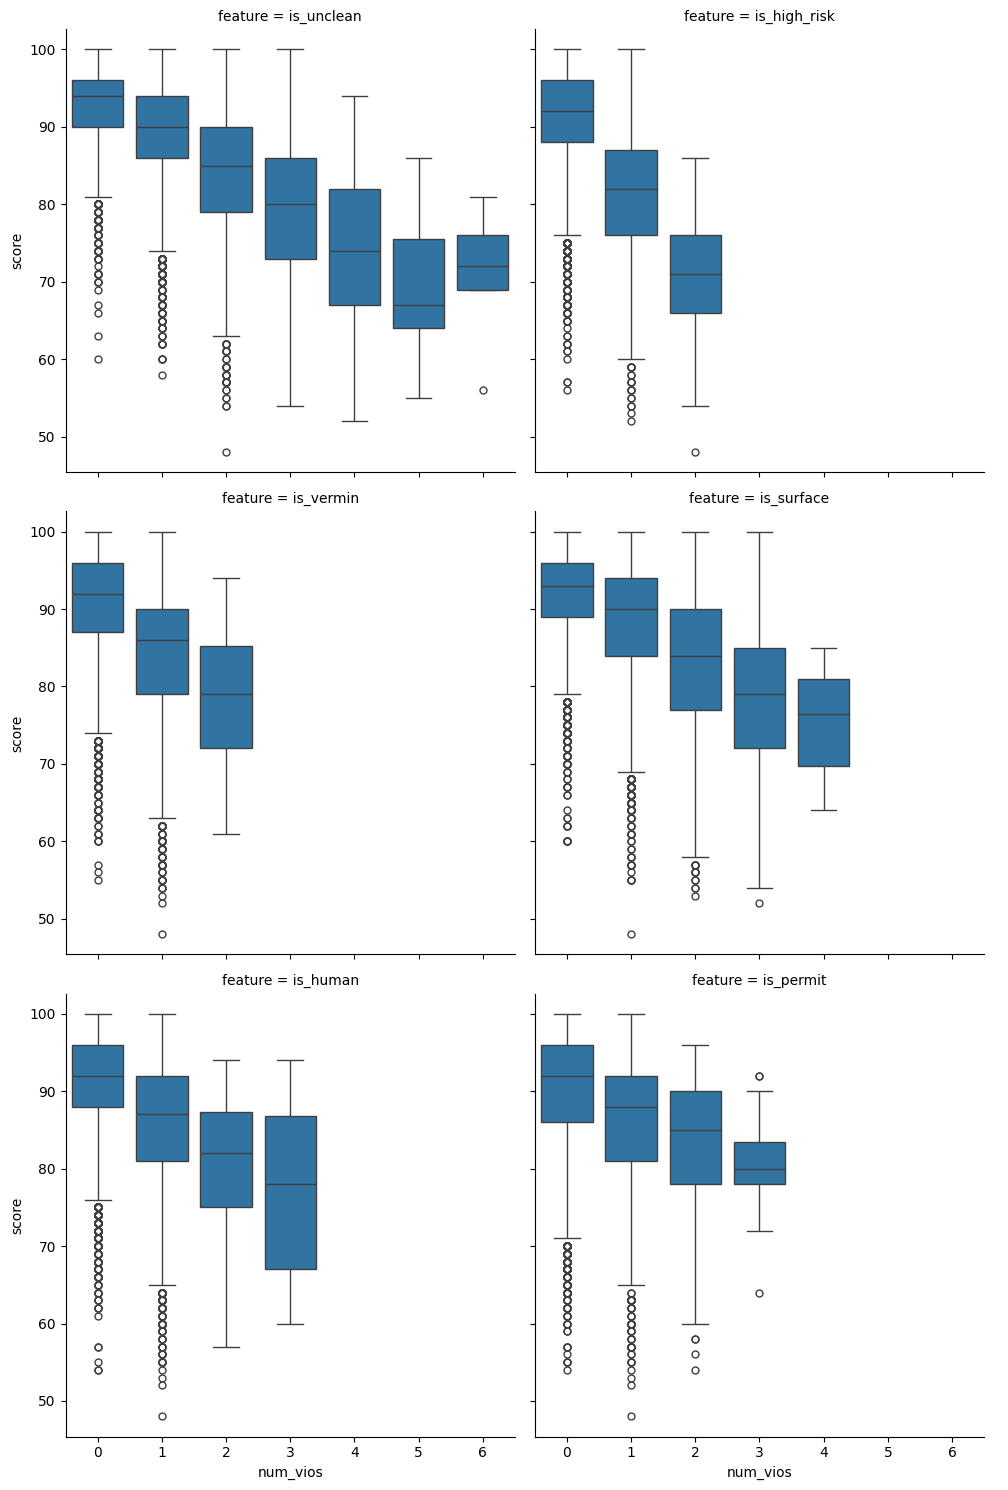

In [69]:
# you will learn this syntax next week. Focus on interpreting for now.
sns.catplot(x='num_vios', y='score',
               col='feature', col_wrap=2,
               kind='box',
               data=violation_type_and_scores);

Above we can observe:
* The inspection score generally goes down with increasing numbers of violations, as expected.
* Depending on the violation keyword, inspections scores on average go down at slightly different rates.
* For example, that if a restaurant inspection involved 2 violations with the keyword "vermin", the average score for that inspection would be a little bit below 80.